In [1]:
import collections
import numpy as np
import pandas as pd
import random

from gensim.matutils import unitvec
from gensim.models import Doc2Vec, Phrases
from gensim.models.doc2vec import LabeledSentence
from pprint import pprint

train_model = False

## Process the raw data into Doc2Vec LabeledSentences

In [2]:
df = pd.read_json('./data/combined_review.json', lines=True)

In [3]:
import string
import re
RE_PUNCT = re.compile('([%s])+' % re.escape(string.punctuation), re.UNICODE)

def preprocess_text(text):
    # Remove all punctuation and make all lowercase 
    return RE_PUNCT.sub(" ", text).lower().split()

In [4]:
def make_restaurant_doc(text, title):
    doc_tag = '_'.join(preprocess_text(title))    
    doc_words = preprocess_text(text)
    return LabeledSentence(doc_words, [doc_tag])

documents = [make_restaurant_doc(text, title) for text, title in zip(df.text.tolist(), df.name.tolist())]

random.shuffle(documents)

In [5]:
print(documents[:10])

[LabeledSentence(words=['i', 'made', 'an', 'order', 'online', 'and', 'they', 'managed', 'to', 'still', 'messed', 'up', 'my', 'order', 'looking', 'at', 'the', 'fact', 'that', 'its', 'all', 'written', 'right', 'in', 'front', 'of', 'them', 'worst', 'part', 'is', 'they', 'wouldn', 't', 'admit', 'it', 'that', 'they', 'made', 'a', 'error', 'and', 'was', 'just', 'being', 'a', 'total', 'jerk', 'worst', 'customer', 'service', 'experience', 'ever', 'had', 'food', 'here', 'with', 'family', 'service', 'is', 'extremely', 'slow', 'servers', 'seem', 'disinterested', 'and', 'messed', 'up', 'the', 'orders', 'it', 's', 'happened', 'two', 'times', 'that', 'i', 'have', 'been', 'here', 'but', 'the', 'food', 'tastes', 'good', 'just', 'wish', 'servers', 'were', 'more', 'energized', 'and', 'not', 'slow', 'terrible', 'service', 'twice', 'now', '2', 'saturdays', 'in', 'a', 'row', 'we', 'walked', 'out', 'of', 'this', 'restaurant', 'having', 'not', 'been', 'seated', 'for', 'over', '10', 'minutes', 'then', 'when',

## Train the Model

In [6]:
if train_model:
    model = Doc2Vec(dm=0, dbow_words=1, min_count=5, negative=3,
                    hs=0, sample=1e-4, window=10, size=100, workers=4)

    model.build_vocab(documents)
    model.train(documents, total_examples=len(documents), epochs=10, start_alpha=0.025, end_alpha=0.01)

## Save the Doc2Vec model

In [7]:
if train_model:
    model.save('restaurants.d2v')

## Load the Doc2Vec model

In [8]:
model = Doc2Vec.load('restaurants.d2v')

## Trying out the Model

In [9]:
# Find words similar to query word
pprint(model.most_similar('asian'))

[('ethnic', 0.6673818230628967),
 ('japanese', 0.6636415123939514),
 ('oriental', 0.651565670967102),
 ('chines', 0.6503488421440125),
 ('korean', 0.6487221717834473),
 ('chinese', 0.64531409740448),
 ('tink', 0.6449849605560303),
 ('ethnicities', 0.6410532593727112),
 ('gimbap', 0.6397929191589355),
 ('transcend', 0.6380088329315186)]


In [10]:
# Find restaurants similar to query word
vec = model['korean']
pprint(model.docvecs.most_similar([vec]))

[('dae_jang_kum', 0.7390689849853516),
 ('mon_ami_korean_bbq', 0.7201499342918396),
 ('seoul_garden_korean_restaurant', 0.7135433554649353),
 ('paldo_market', 0.7040078043937683),
 ('ehwa_restaurant', 0.7025189399719238),
 ('bimq', 0.6904292702674866),
 ('korean_food_express', 0.6831573247909546),
 ('korean_bbq', 0.6829869747161865),
 ('the_owl_s_meat_shop', 0.6814969182014465),
 ('honba_japanese_restaurant', 0.6791638731956482)]


In [11]:
# Find restaurants similar to a query restaurant
for name in df.name.tolist()[:1]:
    print("\nQuery: %s" % name)
    doc_tag = '_'.join(preprocess_text(name))
    pprint(model.docvecs.most_similar(doc_tag))


Query: The Tea Emporium
[('house_of_tea', 0.6938198208808899),
 ('tea_time', 0.6934463977813721),
 ('anteaques', 0.6916553974151611),
 ('maison_métivier', 0.6822661757469177),
 ('steeped_infused', 0.6576128602027893),
 ('davidstea', 0.6560086011886597),
 ('legacy_house_imports_tea_room', 0.6542452573776245),
 ('whittard_of_chelsea', 0.6532135009765625),
 ('teaopia', 0.6514689326286316),
 ('eteaket', 0.6452487111091614)]


In [12]:
# Find words similar to a query restaurant
for name in df.name.tolist()[:1]:
    print("\nQuery: %s" % name)
    doc_tag = '_'.join(preprocess_text(name))
    vec = model.docvecs[doc_tag]
    pprint(model.most_similar([vec]))


Query: The Tea Emporium
[('teas', 0.6899389028549194),
 ('looseleaf', 0.6846389174461365),
 ('erh', 0.6797569990158081),
 ('teabags', 0.6791443824768066),
 ('sloane', 0.6634737253189087),
 ('tetley', 0.6543546915054321),
 ('strainers', 0.65379798412323),
 ('steeping', 0.6454598903656006),
 ('loose', 0.6430106163024902),
 ('whittard', 0.6410861611366272)]


## Visualize the embeddings

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def pca_transform_vecs(vectors, n=50):
    pca = PCA(n_components=n)
    pca.fit(vectors)
    return pca.transform(vectors)

def tsne_plot(restaurants, dims=3, perplexity=6):
    doc_tags = ['_'.join(preprocess_text(restaurant)) for restaurant in restaurants]
    restaurant_vectors = np.array([unitvec(model.docvecs[doc_tag]) for doc_tag in doc_tags])    
    
    # First doing pca on the vectors can reduce the noise and yield a better
    # 2d projection
    reduced_restaurant_vectors = pca_transform_vecs(restaurant_vectors, 50)
    
    tsne = TSNE(n_components=dims)
    tsne_results = tsne.fit_transform(reduced_restaurant_vectors)
    
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.scatter(tsne_results[:,0], tsne_results[:,1])

    # Annotate points with the movie title
    for i, restaurant in enumerate(restaurants):
        ax.annotate(restaurant, xy=(tsne_results[i,0],tsne_results[i,1]), fontsize=12, alpha=.9)

    plt.xlim(min(tsne_results[:,0])-0.3, max(tsne_results[:,0])+0.3) 
    plt.ylim(min(tsne_results[:,1])-0.3, max(tsne_results[:,1])+0.3)
    return fig

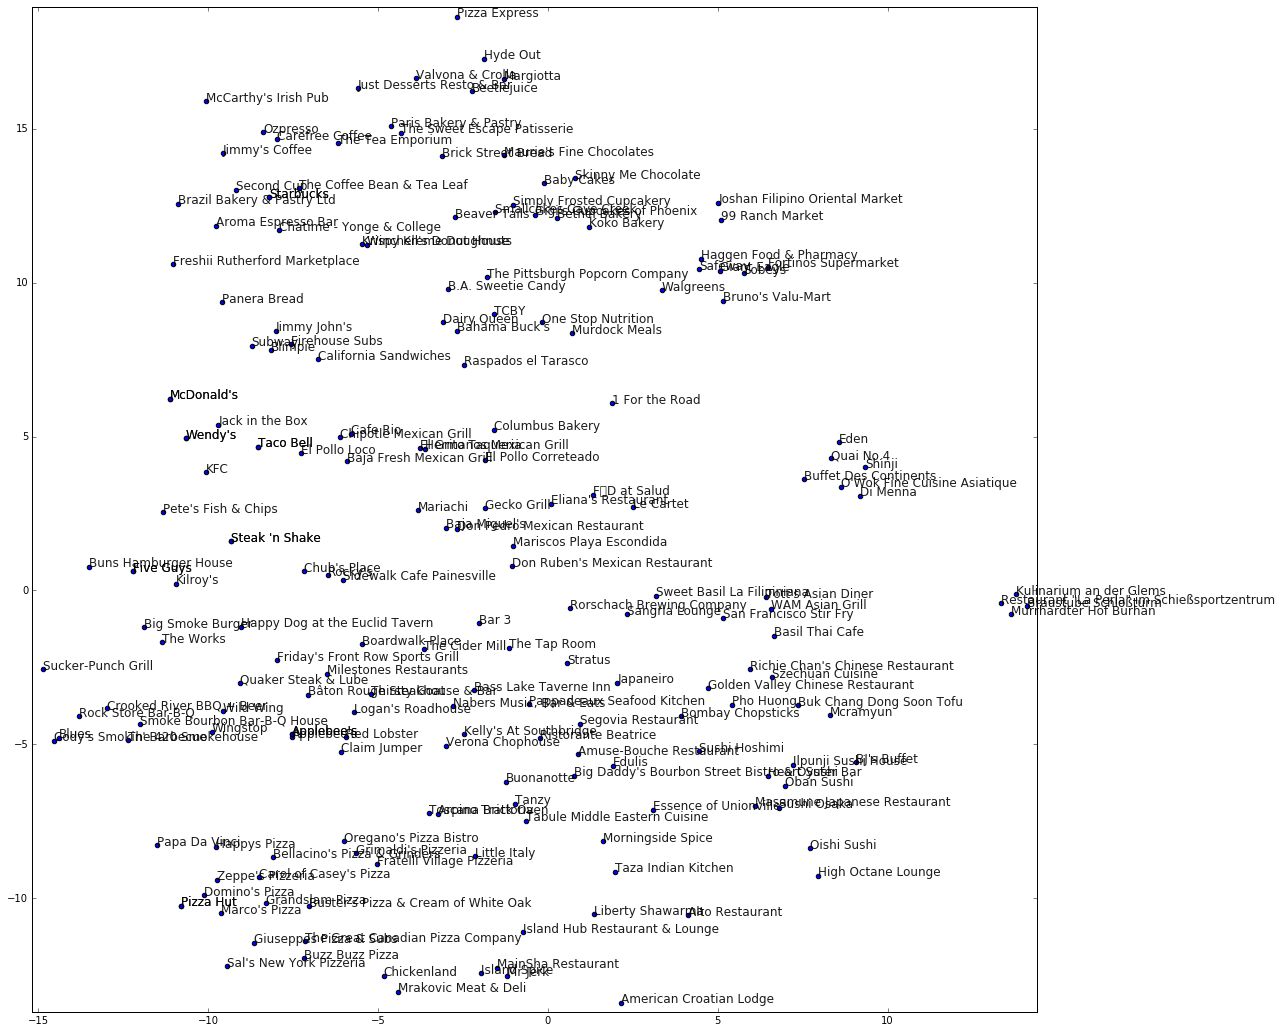

In [14]:
restaurants = df.name.tolist()[:200]
fig = tsne_plot(restaurants, dims=2)